### 探索数据

该数据集与葡萄牙银行业机构的直接营销活动（电话）有关，分类目标是预测客户是否将订阅（是/否）定期存款。

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoderEstimator,StringIndexer,VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator

spark = SparkSession.builder.appName('ml-bank').getOrCreate()

In [2]:
df = spark.read.csv('bank.csv',header=True,inferSchema=True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



特征: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome.

标签: deposit

In [3]:
# 查看前5行
pd.DataFrame(df.take(5),columns = df.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# 查看数据集是否平衡
df.groupBy('deposit').count().toPandas()

,deposit,count
0,no,5873
1,yes,5289


In [5]:
# 数值变量摘要统计
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


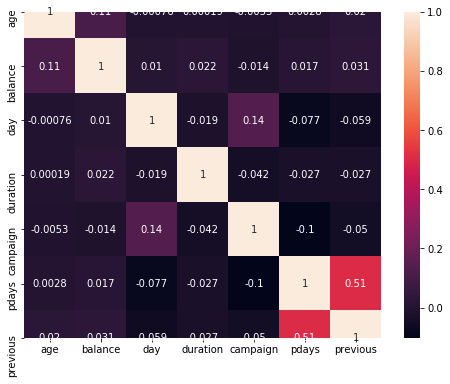

In [6]:
# 自变量之间的相关性
numeric_data = df.select(numeric_features).toPandas()

plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(),annot=True)

没有高度相关的数字变量。因此，我们将所有这些保留为模型。

但是，日期和月份列并不是真正有用的，我们将删除这两列。

In [7]:
df = df.drop('month','day')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



### 特征处理

In [8]:
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol,outputCol=categoricalCol+'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()],outputCols=[categoricalCol+'classVec'])
    stages += [stringIndexer,encoder]
    
label_stringIdx = StringIndexer(inputCol='deposit',outputCol='label')
stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + 'classVec' for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')
stages += [assembler]

In [9]:
# 建立管道
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = cols + ['features','label']
df = df.select(selectedCols)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [10]:
pd.DataFrame(df.take(5), columns=df.columns)

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,deposit,features,label
0,59,admin.,married,secondary,no,2343,yes,no,unknown,1042,1,-1,0,unknown,yes,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
1,56,admin.,married,secondary,no,45,no,no,unknown,1467,1,-1,0,unknown,yes,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,41,technician,married,secondary,no,1270,yes,no,unknown,1389,1,-1,0,unknown,yes,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
3,55,services,married,secondary,no,2476,yes,no,unknown,579,1,-1,0,unknown,yes,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
4,54,admin.,married,tertiary,no,184,no,no,unknown,673,2,-1,0,unknown,yes,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


In [11]:
# 将数据随机分为训练集和测试集
train,test = df.randomSplit([0.7,0.3],seed=2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7764
Test Dataset Count: 3398


### 逻辑回归

In [12]:
lr = LogisticRegression(featuresCol='features',labelCol='label',maxIter=10)
lrModel = lr.fit(train)

In [13]:
# 使用LogisticRegressionModel的属性来获取系数
lrModel.coefficients

DenseVector([-0.1912, -0.3073, -0.157, 0.0934, -0.3095, 0.7131, -0.3085, 0.5898, -0.0685, -0.3342, -0.4521, -0.2221, -0.0426, -0.1971, 0.115, -0.3691, -0.9709, 0.7928, 0.5425, 0.1056, -0.9907, -0.853, -0.5036, 1.9798, -0.0093, 0.0, 0.0052, -0.13, 0.0003, 0.0056])

在训练集上获取评估指标

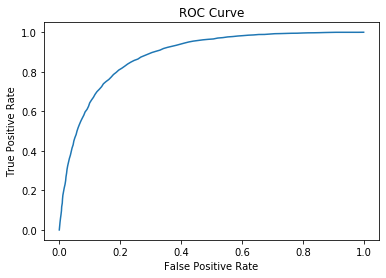

Training set areaUnderROC: 0.8842516808655967


In [14]:
# ROC
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

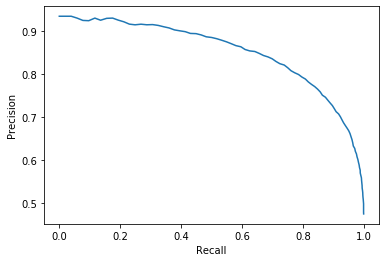

In [15]:
# 查准率和查全率
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

在测试集上进行预测

In [16]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 18|    student|  1.0|[-0.2138024853666...|       1.0|[0.44675206123491...|
| 18|    student|  1.0|[-3.0469826311533...|       1.0|[0.04534792081362...|
| 19|    student|  1.0|[-0.5334561012561...|       1.0|[0.36971116865150...|
| 19|    student|  1.0|[-3.8400845518642...|       1.0|[0.02103960544022...|
| 20|blue-collar|  1.0|[-0.9335334542458...|       1.0|[0.28220840341852...|
| 20|    student|  1.0|[-0.2959968257922...|       1.0|[0.42653638280761...|
| 20|    student|  1.0|[-1.1655461381908...|       1.0|[0.23766098404005...|
| 20|    student|  0.0|[1.44461655126882...|       0.0|[0.80916853301324...|
| 20|    student|  1.0|[-0.8080513657697...|       1.0|[0.30830589321384...|
| 20|    student|  1.0|[-3.3386327858587...|       1.0|[0.03426937682564...|

评估模型

In [17]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.887642600080595


交叉验证

In [18]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())
cv = CrossValidator(estimator=lr,estimatorParamMaps=paramGrid,evaluator=evaluator,numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8866254672280394


### 决策树

由于决策树易于解释，处理分类特征，扩展到多类分类，不需要特征缩放并且能够捕获非线性和特征交互，因此被广泛使用。

In [19]:
dt = DecisionTreeClassifier(featuresCol='features',labelCol='label',maxDepth=3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------+----------+--------------------+
|age|        job|label| rawPrediction|prediction|         probability|
+---+-----------+-----+--------------+----------+--------------------+
| 18|    student|  1.0|[2455.0,494.0]|       0.0|[0.83248558833502...|
| 18|    student|  1.0|  [24.0,154.0]|       1.0|[0.13483146067415...|
| 19|    student|  1.0|[2455.0,494.0]|       0.0|[0.83248558833502...|
| 19|    student|  1.0|[755.0,1088.0]|       1.0|[0.40965816603364...|
| 20|blue-collar|  1.0|[503.0,1919.0]|       1.0|[0.20767960363336...|
| 20|    student|  1.0|[2455.0,494.0]|       0.0|[0.83248558833502...|
| 20|    student|  1.0|[755.0,1088.0]|       1.0|[0.40965816603364...|
| 20|    student|  0.0|[2455.0,494.0]|       0.0|[0.83248558833502...|
| 20|    student|  1.0|[755.0,1088.0]|       1.0|[0.40965816603364...|
| 20|    student|  1.0|  [24.0,154.0]|       1.0|[0.13483146067415...|
+---+-----------+-----+--------------+----------+--------------------+
only s

In [20]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7749287868050635


一个简单的决策树表现不佳。我们将考虑使用诸如随机森林和梯度提升树之类的集成方法来提高。

### 随机森林

In [21]:
rf = RandomForestClassifier(featuresCol='features',labelCol='label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 18|    student|  1.0|[10.4540280318089...|       0.0|[0.52270140159044...|
| 18|    student|  1.0|[4.74740993230936...|       1.0|[0.23737049661546...|
| 19|    student|  1.0|[8.87290510930551...|       1.0|[0.44364525546527...|
| 19|    student|  1.0|[2.17514844313459...|       1.0|[0.10875742215672...|
| 20|blue-collar|  1.0|[6.50611753541491...|       1.0|[0.32530587677074...|
| 20|    student|  1.0|[8.55958995557323...|       1.0|[0.42797949777866...|
| 20|    student|  1.0|[6.07799332157172...|       1.0|[0.30389966607858...|
| 20|    student|  0.0|[15.4680823926888...|       0.0|[0.77340411963444...|
| 20|    student|  1.0|[8.08914620312725...|       1.0|[0.40445731015636...|
| 20|    student|  1.0|[2.69110939274673...|       1.0|[0.13455546963733...|

In [22]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8856241402309407


### GBDT

In [23]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-----------+-----+--------------------+----------+--------------------+
|age|        job|label|       rawPrediction|prediction|         probability|
+---+-----------+-----+--------------------+----------+--------------------+
| 18|    student|  1.0|[-0.1280428848342...|       1.0|[0.43632615498331...|
| 18|    student|  1.0|[-0.8617945597199...|       1.0|[0.15140943982208...|
| 19|    student|  1.0|[-0.1759359922262...|       1.0|[0.41292854345672...|
| 19|    student|  1.0|[-1.2082650577215...|       1.0|[0.08192084656218...|
| 20|blue-collar|  1.0|[-1.0324311675499...|       1.0|[0.11255921741468...|
| 20|    student|  1.0|[-0.1062330658348...|       1.0|[0.44708238409404...|
| 20|    student|  1.0|[-0.3695570516001...|       1.0|[0.32319789536764...|
| 20|    student|  0.0|[1.11929482766523...|       0.0|[0.90366174752023...|
| 20|    student|  1.0|[-0.5776384069944...|       1.0|[0.23952657171299...|
| 20|    student|  1.0|[-1.1464765462102...|       1.0|[0.09170826687981...|

In [24]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8951241541261936


梯度提升树取得了最佳效果，如果想要得到更好的效果，我们还可以尝试使用ParamGridBuilder和CrossValidator对该模型进行调整。